In [62]:
# Imports
import torch
import torchvision 
from torch.utils.data import Dataset 
from torch.utils.data import random_split 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from PIL import Image
import spectral as spec

from dataGen import Patches
from ResNet.ResNet_3D import ResNet_3D as CNN

In [63]:
# Set device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count()

1

In [64]:
# Hyperparameters
in_channels = 1
num_classes = 3
classes = ["background", "leaf", "diseased"]
batch_size = 32
img_size = 20
res_dir = "F:\\Lukas\\Project\\노균병\\code\\result\\23_3_10 ResNet3D_55_25_28\\"
model_dir = res_dir + "ResNet3D_55_25_28_노균병_best.pt"
train_dir = res_dir + "train_25_28.csv"
val_dir = res_dir + "val_25_28.csv"

In [65]:
# Custom image dataset

class Img(Dataset):
    def __init__(self, img_df, transform=None):
        self.img_df = img_df
        self.transform = transform

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        img_path = self.img_df['path'].iloc[idx]
        img = spec.envi.open(img_path)
        np_img = np.array(img[:, :, 5:60])
        label = self.img_df['class'].iloc[idx]
        if self.transform:
            image = self.transform(np_img)
        else:
            image = torch.tensor([np_img])
        return image, label

In [66]:
def tensorToImg(tensor, img_size):
    img = torch.zeros(img_size, img_size, 1)
    for c_y, y in enumerate(tensor[0]):
        for c_x, x in enumerate(y):
            img[c_y][c_x] = x
    return img

In [67]:
def displayImgs(imgs, labels, img_size, save=False):
    fig = plt.figure(figsize=(20,11))
    for pos, i in enumerate(imgs[:8]):
        img = tensorToImg(i, img_size)
        label = "downy mildew"
        if labels[pos] == 0:
            label = "Non-disease"
        fig.add_subplot(4, 8, pos + 1).title.set_text(label)
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    if save:
        fig.savefig('fig.png')

In [68]:
# Transformers

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.ConvertImageDtype(torch.float)])
img_transform

Compose(
    ToTensor()
    Resize(size=(20, 20), interpolation=bilinear)
    ConvertImageDtype()
)

In [69]:
def getDataset(patch, dc, train_frac = .7):
    patch_ds = patch.generateAndSplitDataset(
        dataset_composition = [
            ['diseased',    dc[0]],
            ['leaf',        dc[1]],
            ['background',  dc[2]]],
        data_type = 'hdr',
        train_frac = train_frac)
    for p in patch_ds:
        p.loc[(p['class'] == 'background'), 'class'] = 0
        p.loc[(p['class'] == 'leaf'), 'class'] = 1
        p.loc[(p['class'] == 'diseased'), 'class'] = 2

        print(p.describe())
    
    return patch_ds

In [71]:
patch_ds = (pd.read_csv(train_dir),
            pd.read_csv(val_dir))

In [73]:
patch_14 = Patches("D:\\gyeongsang_22_10_14\\PATCHES")
patch_21 = Patches("D:\\gyeongsang_22_10_21_1\\PATCHES")

In [74]:
patch_14_ds = getDataset(patch_14, [48, 450, 450], train_frac = .3)
patch_21_ds = getDataset(patch_21, [61, 500, 500], train_frac = .3)

                                                     path type  class
count                                                 284  284    284
unique                                                284    1      3
top     D:\gyeongsang_22_10_14\PATCHES\STACK_75_BANDS_...  hdr      1
freq                                                    1  284    135
                                                     path type  class
count                                                 664  664    664
unique                                                664    1      3
top     D:\gyeongsang_22_10_14\PATCHES\STACK_75_BANDS_...  hdr      1
freq                                                    1  664    315
                                                     path type  class
count                                                 318  318    318
unique                                                318    1      3
top     D:\gyeongsang_22_10_21_1\PATCHES\STACK_75_BAND...  hdr      1
freq                

In [75]:
def extractDs(ds, d):
    ds = (patch_ds[0][patch_ds[0]["path"].str.contains(d)],
          patch_ds[1][patch_ds[1]["path"].str.contains(d)])
    
    return ds

In [76]:
patch_25_ds = extractDs(patch_ds, "gyeongsang_22_10_25")
patch_28_ds = extractDs(patch_ds, "gyeongsang_22_10_28")

In [77]:
train_patch = patch_ds[0]
val_patch = patch_ds[1]

In [78]:
train_dataset = Img(img_df=train_patch, transform=None)
val_dataset = Img(img_df=val_patch, transform=None)

print(f"The num of training dataset is {len(train_dataset)} and num of validation dataset is {len(val_dataset)}")

The num of training dataset is 1549 and num of validation dataset is 664


In [79]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

In [80]:
ds_14 = DataLoader(dataset=Img(img_df=pd.concat([patch_14_ds[0], patch_14_ds[1]]), transform=None), 
           batch_size=batch_size, shuffle=True)
ds_21 = DataLoader(dataset=Img(img_df=pd.concat([patch_21_ds[0], patch_21_ds[1]]), transform=None), 
           batch_size=batch_size, shuffle=True)
ds_25 = DataLoader(dataset=Img(img_df=pd.concat([patch_25_ds[0], patch_25_ds[1]]), transform=None), 
           batch_size=batch_size, shuffle=True)
ds_28 = DataLoader(dataset=Img(img_df=pd.concat([patch_28_ds[0], patch_28_ds[1]]), transform=None), 
           batch_size=batch_size, shuffle=True)
ds_all = DataLoader(dataset=Img(img_df=pd.concat([patch_ds[0], patch_ds[1]]), transform=None), 
           batch_size=batch_size, shuffle=True)

In [81]:
next(iter(train_loader))[0].shape

torch.Size([32, 1, 20, 20, 55])

In [82]:
# Initialize network

model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

In [83]:
# Load weights

model.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

In [84]:
model.eval()

ResNet_3D(
  (conv1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (conv4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool2): MaxPool3d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (downsample): Sequential(
    (0): Conv3d(1, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Linear(i

In [85]:
# Predict 
def predictDataset(loader, model, savefig=False):
    actual = np.array([])
    prediction = np.array([])
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            actual = np.append(actual, y.cpu().detach().numpy())
            prediction = np.append(prediction, predictions.cpu().detach().numpy())
    model.train()
    
    return actual, prediction

In [87]:
actual_test, prediction_test = predictDataset(test_loader, model)
actual_14, prediction_14 = predictDataset(ds_14, model)
actual_21, prediction_21 = predictDataset(ds_21, model)
actual_25, prediction_25 = predictDataset(ds_25, model)
actual_28, prediction_28 = predictDataset(ds_28, model)
actual_all, prediction_all = predictDataset(ds_all, model)

In [88]:
def drawConfusionMatrix(actual, prediction, normalize=True, savefig=False):
    confusion_matrix = metrics.confusion_matrix(actual, prediction)
    cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    if normalize:
        confusion_matrix = cmn
    
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2"])
    cm_display.plot()
    plt.show()
    
    if savefig:
        plt.savefig('confusion_matrix.png')

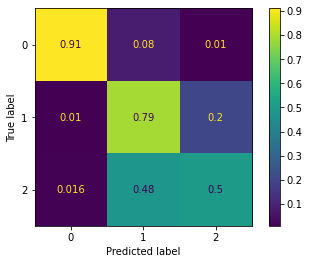

In [89]:
drawConfusionMatrix(actual_test, prediction_test, normalize=True)

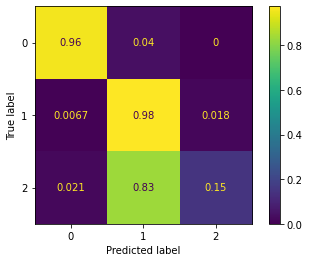

In [90]:
drawConfusionMatrix(actual_14, prediction_14, normalize=True)

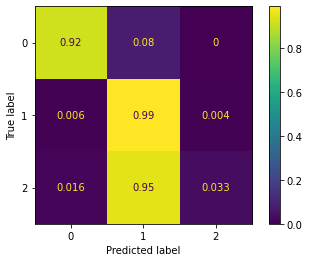

In [91]:
drawConfusionMatrix(actual_21, prediction_21, normalize=True)

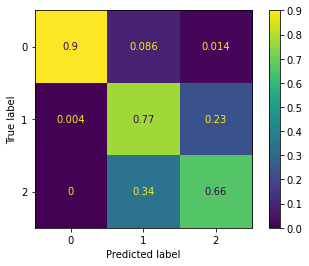

In [92]:
drawConfusionMatrix(actual_25, prediction_25, normalize=True)

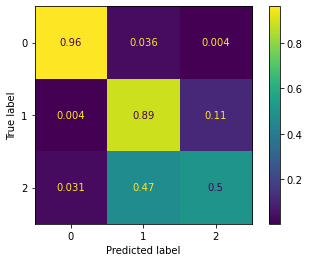

In [93]:
drawConfusionMatrix(actual_28, prediction_28 , normalize=True)

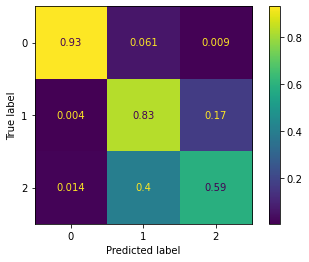

In [94]:
drawConfusionMatrix(actual_all, prediction_all , normalize=True)